<h5>Project Pipeline</h5>
<li>Problem Definition : <strong>Diabetic Retinography</strong></li>
<li>Data Collection : <strong>Taken from Kaggle</strong></li>
<li>Data Annotation : <strong>Not Needed</strong></li>
<li>Data Processing : <strong>crop/resize/normalize, splitting in train/test</strong></li>
<li>Data Augmentation : <strong>rotate/flip/color</strong></li>
<li>Model Training : <strong>CNN</strong></li>
<li>Evalutaion : <strong>Accuracy, Precision, Recall, F1</strong></li>
<li>Saving Model : <strong>Normal</strong></li>
<li>API for Deployment : <strong>FastApi</strong></li>
<li>Testing</li>



In [1]:
#importing all the required libraries
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
#building the data transformation pipeline
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.49),(0.49))
])

In [4]:
#Loading the dataset and applying transformations
full_dataset = datasets.ImageFolder(root="dataset/train", transform=transform)

#splitting dataset in train - test
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

#dataloader
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
def prev_img(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show() 

full_dataset.classes

['Healthy', 'Mild', 'Moderate', 'Proliferate', 'Severe']

In [6]:
#implementing CNN 

class RetinographyNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        #224->112->56->28 due to pulling layer, 
        #128 filter from Conv2d
        self.classifier = nn.Sequential(
            nn.Flatten(),

            #input layer
            nn.Linear(128*28*28, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            #hidden layer
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            #hidden layer
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            #output layer
            nn.Linear(64,num_classes)            
        )

        
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [7]:
#training loop
model = RetinographyNN(5)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.6)

epochs = 5

for epoch in range(epochs):
    model.train()

    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        #forward pass
        outputs = model(images)

        #loss calc
        loss = criterion(outputs, labels)

        #grad clear
        optimizer.zero_grad()

        #backward pass
        loss.backward()

        #update grad
        optimizer.step()

        #loss tracking
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch : {epoch}, Loss : {avg_loss}")
    torch.cuda.empty_cache()

Epoch : 0, Loss : 1.3538787419145757
Epoch : 1, Loss : 1.2256080088290302
Epoch : 2, Loss : 1.1881252324039286
Epoch : 3, Loss : 1.154372900724411
Epoch : 4, Loss : 1.1298629993742162


In [71]:
torch.cuda.empty_cache()

In [8]:
#Evaluation
model.eval()

total = 0
correct = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total = total + labels.shape[0]
        correct = correct + (predicted == labels).sum().item()
    
    print(f"Accuracy : {correct/total}")


Accuracy : 0.5704697986577181


In [84]:
#classification report
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

print("Classification Report :-")
print(classification_report(y_true, y_pred))

Classification Report :-
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       167
           1       0.59      0.45      0.51       106
           2       0.44      0.82      0.57       171
           3       0.00      0.00      0.00        87
           4       0.69      0.14      0.23        65

    accuracy                           0.59       596
   macro avg       0.52      0.47      0.44       596
weighted avg       0.55      0.59      0.53       596



c:\python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


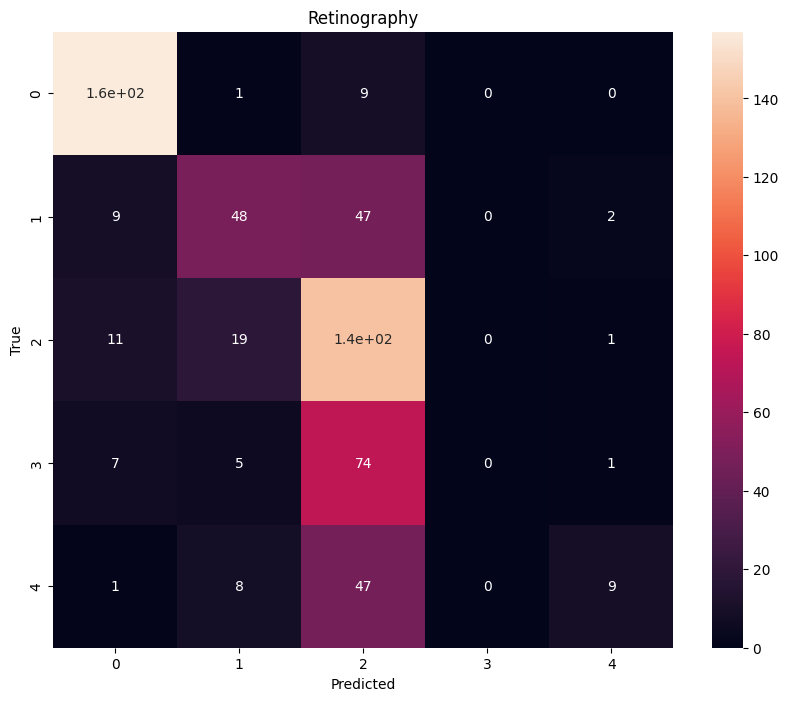

In [85]:
#confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sn.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Retinography")
plt.show()

In [9]:
#saving the normal model
torch.save(model.state_dict(), "normal_retinography_cnn_model.pth")